# Problem A: 1D Elastostatics
Consider a rod made of linearly elastic material subjected to some load. Static problems will be considered here, by which is meant it is not necessary to know how the load was applied, or how the material particles moved to reach the stressed state; it is
necessary only that the load is applied slowly enough so that the accelerations are zero, or that it was applied sufficiently long ago that any vibrations have died away and movement has ceased. 

The equations governing the static response of the rod are: 
$$
-\frac{d}{dx} \left( E(x) \frac{du}{dx} \right) = f, \quad x \in (0, L) \tag{1}
$$
where
- $u(x):$ displacement field of the rod
- $E(x):$ Young’s modulus 
- $f=9.81:$ body force per unit length (e.g., gravity)
- $L=1.:$ Length of the rod

We consider the fixation of both sides of the rod, which leads to the following boundary conditions:
- $u(0) = u(L) = 0$

## Task 2: Recover the Young's modulus $E(x)$ from the observation of displacement field $u(x)$
In this task, the Young's modulus $E(x)>0$ of the rod is unknown. However, we observe the displacement field $u_{obs}$ (contaminated by noise with noise level $\sim 5\%$) on a set of randomly placed sensors $x_{obs}$ (with size $N_{obs}=250$). Moreover, we are able to measure the Young's modulus of the rod at two boundary sides, i.e., $E(0)=E(1)=1$.

### The goals
- Please select a suitable deep learning method for solving this inverse problem to recover the Young's modulus $E(x)$, and explain the reason for using it
- Report your setups for the implementation, such as network structure, activation function, optimizer (with learning rate), epoch (with batch size), loss weights, and other tricks that are used for improvement.
- Compute the $L^2$ relative error (on testing dataset) at each training epoch and plot the ```Error vs. epcoh``` curve (and report the final error). The $L^2$ relative error between the prediction $e_{pred} (or\ u_{pred})$ and the truth $e_{true} (or\ u_{true})$ is defined as follows:
  $$error = \sqrt{\frac{\sum^{n}_i|e_{pred}(x_i)-e_{true}(x_i)|^2}{\sum^{n}_{i}|e_{true}(x_i)|^2}}$$
- Plot the predicted solution (and the ground truth reference) and the pointwise absolute error using separate figures with ```matplotlib```.
  
### Dataset
The observation and the ground truth references are given in the dataset ```LinearElasticity1d_inverse.h5```:
- ```x_obs```: the observation sensors
- ```u_obs```: the observed displacement field $u$ (contaminated by noie)
- ```x_test```: the locations where the ground truth is evaluated (Should not be used for training)
- ```e_test```: the ground truth reference for Young's modulus (Should not be used for training)
- ```u_test```: the ground truth reference for displacement field (Should not be used for training)
- Link to dataset: [https://www.kaggle.com/datasets/yhzang32/physicsinformedlearning4pde](https://www.kaggle.com/datasets/yhzang32/physicsinformedlearning4pde)

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import trange

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32
print(f"Using device: {device}")

torch.manual_seed(1234)

Using device: cpu


In [2]:
# Read the data from the file
with h5py.File('LinearElasticity1d_inverse.h5', 'r') as file:
    print(file.keys())
    #
    x_obs = torch.tensor(file['x_obs'], dtype=dtype).unsqueeze(1)
    u_obs = torch.tensor(file['u_obs'], dtype=dtype).unsqueeze(1)

    x_test = torch.tensor(file['x_test'], dtype=dtype)
    e_test = torch.tensor(file['e_test'], dtype=dtype)
    u_test = torch.tensor(file['u_test'], dtype=dtype).unsqueeze(1)

# Number of collocation points
n_int = len(x_obs)

print("Number of integral points:", n_int)

print("\nObservation dataset...")
print("Size of x_obs:", x_obs.shape)
print("Size of u_obs:", u_obs.shape)

print("\nTesting dataset...")
print("Size of x_test:", x_test.shape)
print("Size of e_test:", e_test.shape)
print("Size of u_test:", u_test.shape)

x_int, w_int = np.polynomial.legendre.leggauss(n_int)
x_int = x_int * 0.5 + 0.5  # Scale to [0, 1]
x_int, w_int = torch.tensor(x_int, dtype=dtype).unsqueeze(1), torch.tensor(w_int, dtype=dtype).unsqueeze(1)

print("\nIntegration points and weights...")
print("Size of x_int:", x_int.shape)
print("Size of w_int:", w_int.shape)

<KeysViewHDF5 ['e_test', 'u_obs', 'u_test', 'x_obs', 'x_test']>
Number of integral points: 250

Observation dataset...
Size of x_obs: torch.Size([250, 1])
Size of u_obs: torch.Size([250, 1])

Testing dataset...
Size of x_test: torch.Size([1001, 1])
Size of e_test: torch.Size([1001, 1])
Size of u_test: torch.Size([1001, 1])

Integration points and weights...
Size of x_int: torch.Size([250, 1])
Size of w_int: torch.Size([250, 1])


/tmp/ipykernel_210728/851211228.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647175880/work/torch/csrc/utils/tensor_new.cpp:278.)
  x_test = torch.tensor(file['x_test'], dtype=dtype)


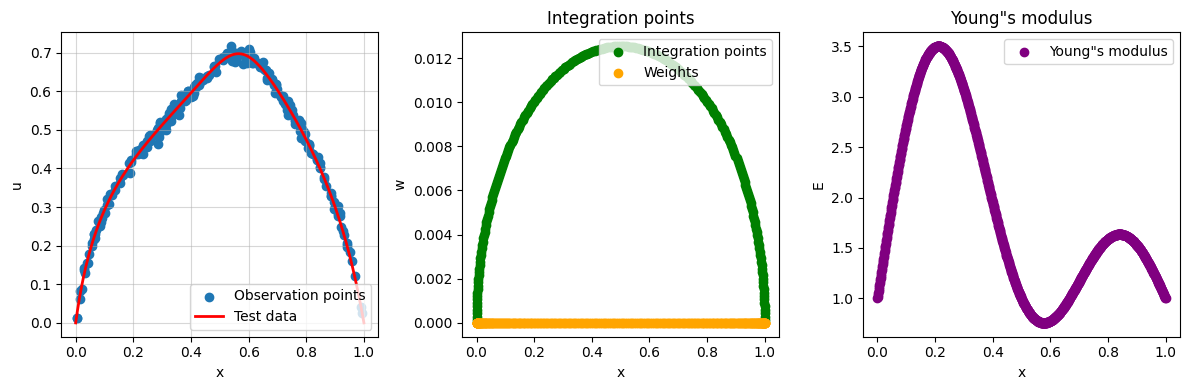

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].scatter(x_obs, u_obs, label="Observation points")
axs[0].plot(x_test, u_test, color="red", label="Test data", linewidth=2)
axs[0].grid(True, linestyle='-', alpha=0.5)
axs[0].set_xlabel("x")
axs[0].set_ylabel("u")
axs[0].legend(loc="lower right")

axs[1].scatter(x_int, w_int, color="green" , label="Integration points")
axs[1].scatter(x_int, torch.zeros_like(x_int), color="orange", label="Weights")
axs[1].set_title("Integration points")
axs[1].set_xlabel("x")
axs[1].set_ylabel("w")
axs[1].legend(loc="upper right")

axs[2].scatter(x_test, e_test, color="purple", label="Young\"s modulus")
axs[2].set_title("Young\"s modulus")
axs[2].set_xlabel("x")
axs[2].set_ylabel("E")
axs[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

In [4]:
import torch.nn as nn
from torchsummary import summary

class MLP(nn.Module):
    """Residual MLP using custom activation and residual blocks."""
    def __init__(self, layers: list, dtype=None):
        super().__init__()
        
        self.net = nn.ModuleList()
        hidden_in = layers[0]
        for hidden_out in layers[1:]:
            self.net.append(nn.Linear(hidden_in, hidden_out, dtype=dtype))
            hidden_in = hidden_out

    def activation(self, x):
        x = torch.tanh(x)
        x = torch.sin(x * torch.pi + torch.pi)
        return x

    def forward(self, x):
        # Forward pass through each of the residual blocks
        for layer in self.net[:-1]:
            x = self.activation(layer(x))
        x = self.net[-1](x)
        return x

class ResidualNN(nn.Module):
    """Residual MLP using custom activation and residual blocks."""
    def __init__(self, layers: list, dtype=None):
        super().__init__()
        assert len(layers) % 2 == 1, "Layers must have odd length"
        
        self.net = nn.ModuleList()
        hidden_in = layers[0]
        for hidden_out in layers[1:]:
            self.net.append(nn.Linear(hidden_in, hidden_out, dtype=dtype))
            hidden_in = hidden_out

    def activation(self, x):
        x = torch.relu(x ** 3)
        return x

    def block(self, s, net1, net2):
        """Residual block with two linear layers and custom activation."""
        # Forward pass through the two linear layers with activation
        x = self.activation(net1(s))
        x = self.activation(net2(x))
        # Add the input to the output (residual connection)
        return x + s

    def forward(self, s):
        # Forward pass through each of the residual blocks
        for i in range((len(self.net) - 1) // 2):
            s = self.block(s, self.net[2*i], self.net[2*i + 1])
        # Final layer without activation
        return self.net[-1](s)
    
summary(ResidualNN([1, 80, 80, 80, 80, 80, 1], dtype=dtype).to(device), (1,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 80]             160
            Linear-2                   [-1, 80]           6,480
            Linear-3                   [-1, 80]           6,480
            Linear-4                   [-1, 80]           6,480
            Linear-5                    [-1, 1]              81
Total params: 19,681
Trainable params: 19,681
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.08
Estimated Total Size (MB): 0.08
----------------------------------------------------------------


In [5]:
from torch.autograd import grad, Variable

class LossClass(object):
    def __init__(self, u_model, e_model, x_int, w_int, x_obs, u_obs, f=9.81, device="cpu"):
        # Store models
        self.u_model = u_model.to(device)
        self.e_model = e_model.to(device)
        # Store integration points and weights enable gradient computation
        self.x = Variable(x_int, requires_grad=True).to(device)
        self.w = w_int.to(device)
        # Store observation points and values
        self.x_obs = x_obs.to(device)
        self.u_obs = u_obs.to(device)
        # Store boundary points and values
        self.x_bd = torch.tensor([[0.], [1.]], device=device)
        self.u_bd = torch.tensor([[0.], [0.]], device=device)
        self.e_bd = torch.tensor([[1.], [1.]], device=device)
        # Store external forces
        self.f = torch.ones_like(self.x) * f
        # Loss model
        self.get_loss = nn.MSELoss()

    def _residual_loss(self):
        """Compute the energy functional loss."""
        # Predict displacement field and Young's modulus
        u = self.u_model(self.x)
        e = self.e_model(self.x)
        # Compute gradient of u with respect to x
        du_dx = grad(inputs=self.x, outputs=u, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        # Compute stress e * du_dx
        s = e * du_dx
        # Compute gradient of stress with respect to x
        ds_dx = grad(inputs=self.x, outputs=s, grad_outputs=torch.ones_like(s), create_graph=True)[0]
        # Compute weighted residual of the PDE
        residual = (- ds_dx - self.f)
        # Integrate the residual over the domain
        #loss = self.get_loss(residual, torch.zeros_like(residual))
        loss = 0.5 * torch.mean(self.w * residual**2)
        return loss
    
    def _bd_loss_e(self):
        """Compute the boundary loss for Young's modulus."""
        # Predict Young's modulus at boundary points
        e = self.e_model(self.x_bd)
        # Compute the mean squared error between predicted and boundary Young's modulus
        loss = self.get_loss(e, self.e_bd)
        return loss
    
    def _data_loss(self):
        """Compute the data loss."""
        # Predict displacement field at observation points
        u = self.u_model(self.x_obs)
        # Compute the mean squared error between predicted and observed displacements
        loss = self.get_loss(u, self.u_obs)
        return loss

    def __call__(self, w_pde, w_data, w_bd_e):
        """Compute the total loss as a weighted sum of energy and data loss."""
        loss = 0.0
        loss += self._residual_loss() * w_pde
        loss += self._data_loss() * w_data
        loss += self._bd_loss_e() * w_bd_e

        return loss
    
class ErrorClass(object):
    """Prediction error."""
    def __init__(self, u_model, e_model, x_test, u_test, e_test, device="cpu"):
        # Store models
        self.u_model = u_model.to(device)
        self.e_model = e_model.to(device)
        # Store test data
        self.x_test = x_test.to(device)
        self.u_test = u_test.to(device)
        self.e_test = e_test.to(device)

    def _error_e(self):
        """Compute the error in Young's modulus."""
        # Predict Young's modulus at test points
        e_pred = self.e_model(self.x_test)
        # Compute the mean squared error between predicted and true Young's modulus
        num = torch.sum((e_pred - self.e_test)**2, dim=0)
        den = torch.sum(self.e_test**2, dim=0)
        error = torch.sqrt(num/den)
        return error
    
    def _error_u(self):
        """Compute the error in displacement field."""
        # Predict displacement field at test points
        u_pred = self.u_model(self.x_test)
        # Compute the mean squared error between predicted and true displacements
        num = torch.sum((u_pred - self.u_test)**2, dim=0)
        den = torch.sum(self.u_test**2, dim=0)
        error = torch.sqrt(num/den)
        return error

    def __call__(self):
        """Compute the total error as a weighted sum of displacement and Young's modulus errors."""
        error_u = self._error_u()
        error_e = self._error_e()
        return error_u, error_e

  5%|▌         | 507/10000 [00:05<01:44, 91.23it/s] 

Epoch 500/10000, Loss: 0.0107, Error u: 0.0824, Error E: 0.4377, Learning rate: 0.001000


 10%|█         | 1009/10000 [00:10<01:37, 92.13it/s]

Epoch 1000/10000, Loss: 0.0067, Error u: 0.0650, Error E: 0.5370, Learning rate: 0.001000


 15%|█▌        | 1512/10000 [00:15<01:24, 100.92it/s]

Epoch 1500/10000, Loss: 0.0057, Error u: 0.0602, Error E: 0.5318, Learning rate: 0.001000


 20%|██        | 2015/10000 [00:22<01:21, 97.74it/s] 

Epoch 2000/10000, Loss: 0.0070, Error u: 0.0678, Error E: 0.5997, Learning rate: 0.001000


 25%|██▌       | 2514/10000 [00:27<01:14, 100.75it/s]

Epoch 2500/10000, Loss: 0.0042, Error u: 0.0502, Error E: 0.4481, Learning rate: 0.000500


 30%|███       | 3014/10000 [00:32<01:15, 91.98it/s] 

Epoch 3000/10000, Loss: 0.0042, Error u: 0.0499, Error E: 0.4229, Learning rate: 0.000500


 35%|███▌      | 3514/10000 [00:37<01:07, 96.36it/s] 

Epoch 3500/10000, Loss: 0.0033, Error u: 0.0445, Error E: 0.3933, Learning rate: 0.000500


 40%|████      | 4017/10000 [00:42<01:01, 96.65it/s] 

Epoch 4000/10000, Loss: 0.0153, Error u: 0.0402, Error E: 0.3505, Learning rate: 0.000500


 45%|████▌     | 4514/10000 [00:47<01:03, 86.74it/s] 

Epoch 4500/10000, Loss: 0.0012, Error u: 0.0205, Error E: 0.1443, Learning rate: 0.000250


 50%|█████     | 5019/10000 [00:54<00:49, 100.22it/s]

Epoch 5000/10000, Loss: 0.0007, Error u: 0.0116, Error E: 0.0800, Learning rate: 0.000250


 55%|█████▌    | 5510/10000 [00:59<00:45, 97.75it/s] 

Epoch 5500/10000, Loss: 0.0006, Error u: 0.0073, Error E: 0.0520, Learning rate: 0.000250


 60%|██████    | 6012/10000 [01:04<00:44, 89.32it/s] 

Epoch 6000/10000, Loss: 0.0005, Error u: 0.0057, Error E: 0.0413, Learning rate: 0.000250


 65%|██████▌   | 6516/10000 [01:09<00:36, 96.24it/s] 

Epoch 6500/10000, Loss: 0.0005, Error u: 0.0046, Error E: 0.0328, Learning rate: 0.000125


 70%|███████   | 7011/10000 [01:14<00:29, 100.41it/s]

Epoch 7000/10000, Loss: 0.0005, Error u: 0.0043, Error E: 0.0284, Learning rate: 0.000125


 75%|███████▌  | 7511/10000 [01:19<00:26, 94.41it/s] 

Epoch 7500/10000, Loss: 0.0005, Error u: 0.0048, Error E: 0.0346, Learning rate: 0.000125


 80%|████████  | 8014/10000 [01:25<00:21, 91.63it/s] 

Epoch 8000/10000, Loss: 0.0005, Error u: 0.0043, Error E: 0.0303, Learning rate: 0.000125


 85%|████████▌ | 8514/10000 [01:30<00:16, 89.53it/s] 

Epoch 8500/10000, Loss: 0.0005, Error u: 0.0043, Error E: 0.0288, Learning rate: 0.000063


 90%|█████████ | 9021/10000 [01:36<00:09, 101.07it/s]

Epoch 9000/10000, Loss: 0.0005, Error u: 0.0043, Error E: 0.0279, Learning rate: 0.000063


 95%|█████████▌| 9513/10000 [01:41<00:04, 108.11it/s]

Epoch 9500/10000, Loss: 0.0005, Error u: 0.0042, Error E: 0.0271, Learning rate: 0.000063


100%|██████████| 10000/10000 [01:46<00:00, 94.16it/s]


Epoch 10000/10000, Loss: 0.0005, Error u: 0.0042, Error E: 0.0268, Learning rate: 0.000063


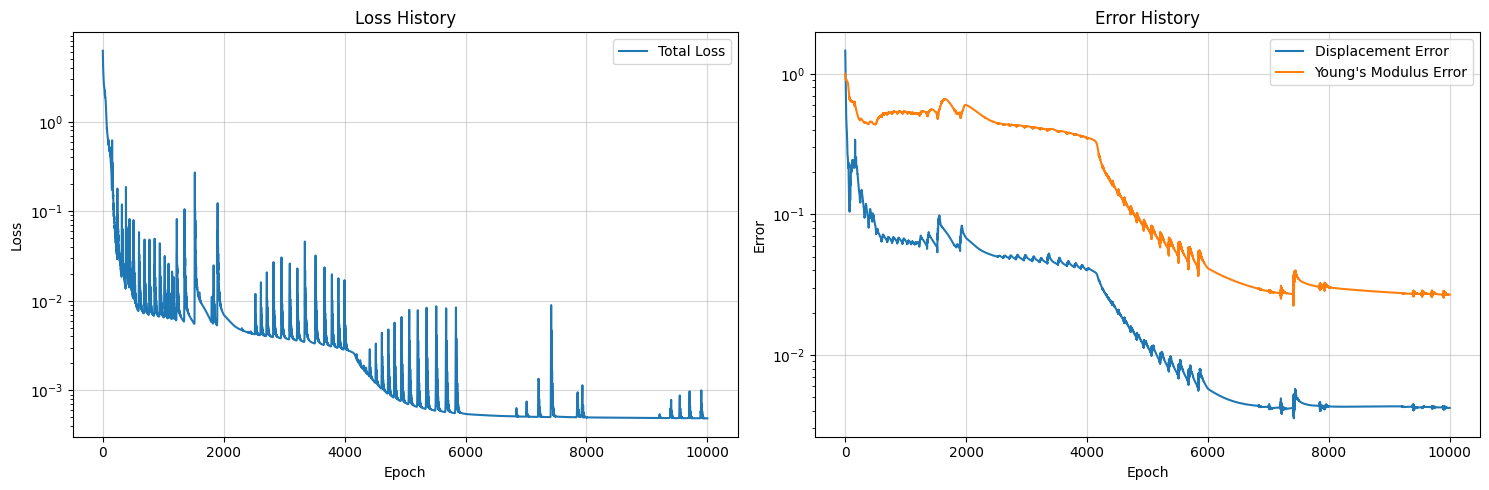

In [6]:
m = 80
u_model = ResidualNN([1, m, m, m, m, m, 1], dtype = torch.float32).to(device)
e_model = ResidualNN([1, m, m, m, m, m, 1], dtype = torch.float32).to(device)

epochs = 10000
lr = 1e-3

optimizer = torch.optim.Adam(params=list(u_model.parameters()) + list(e_model.parameters()), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)
loss_class = LossClass(u_model, e_model, x_int, w_int, x_obs, u_obs)
error_class = ErrorClass(u_model, e_model, x_test, u_test, e_test)

w_pde = 5.0
w_data = 5.0
w_bd_e = 1.0

loss_history = []
error_u_history, error_e_history = [], []
for epoch in trange(epochs):
    # Zero gradients
    optimizer.zero_grad()
    # Compute loss
    loss = loss_class(w_pde, w_data, w_bd_e)
    # Backpropagate the loss and update model parameters 
    loss.backward()
    optimizer.step()
    # Compute error
    with torch.no_grad():
        error_u, error_e = error_class()
        loss_history.append(loss.item())
        error_u_history.append(error_u.item())
        error_e_history.append(error_e.item())
        if (epoch + 1) % 500 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Error u: {error_u.item():.4f}, Error E: {error_e.item():.4f}, Learning rate: {scheduler.get_last_lr()[0]:.6f}")
    # Update the learning rate
    scheduler.step()

# Plot losses
def plot_loss(loss_list, ax, title="Loss"):
    """Plot the loss history."""
    ax.semilogy(loss_list, label=title)
    ax.grid(True, linestyle='-', alpha=0.5)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend(loc="upper right")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_loss(loss_history, axes[0], title="Total Loss")
plot_loss(error_u_history, axes[1], title="Displacement Error")
plot_loss(error_e_history, axes[1], title="Young's Modulus Error")
axes[1].set_title("Error History")
axes[1].legend(loc="upper right")
axes[0].set_title("Loss History")
axes[0].set_xlabel("Epoch")
axes[1].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[1].set_ylabel("Error")
plt.tight_layout()
plt.show()

In [12]:
def plot_prediction(x_test, u_test, x_query, u_query, who="u"):
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(x_query, u_query, label=rf"Pred. ${who}$", linewidth=2.0)
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(rf"${who}$")
    ax.legend(loc="upper right")
    fig.tight_layout()
    fig.savefig(f"task2_plot_{who}_pred.pdf")
    plt.close(fig)

def plot_true(x_test, u_test, who="u"):
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(x_test, u_test, label=rf"True ${who}$")
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(rf"${who}$")
    ax.legend(loc="upper right")
    fig.tight_layout()
    fig.savefig(f"task2_plot_{who}_true.pdf")
    plt.close(fig)

def plot_errors(error_u_history, error_e_history):
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.semilogy(error_u_history, label=r"$L^2$ relative error in $u$")
    ax.semilogy(error_e_history, label=r"$L^2$ relative error in $E$")
    ax.set_xlabel(r"epoch")
    ax.set_ylabel(r"error")
    ax.legend(loc="upper right")
    fig.tight_layout()
    fig.savefig("task2_error_vs_epoch.pdf")
    plt.close(fig)

def plot_pointwise_absolute_error_u(x_query, u_test, u_query):
    fig, ax = plt.subplots(figsize=(6, 4))
    u_query = u_query.view(-1)
    u_test = u_test.view(-1)
    abs_error = torch.abs(u_test - u_query)
    ax.semilogy(x_query, abs_error, label="Pointwise absolute error")
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$|u_{pred} - u_{true}|$")
    ax.legend(loc="upper right")
    fig.tight_layout()
    fig.savefig("task2_u_pointwise_absolute_error.pdf")
    plt.close(fig)

def plot_pointwise_absolute_error_e(x_query, e_test, e_query):
    fig, ax = plt.subplots(figsize=(6, 4))
    e_query = e_query.view(-1)
    e_test = e_test.view(-1)
    abs_error = torch.abs(e_test - e_query)
    ax.semilogy(x_query, abs_error, label="Pointwise absolute error")
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$|E_{pred} - E_{true}|$")
    ax.legend(loc="upper right")
    fig.tight_layout()
    fig.savefig("task2_E_pointwise_absolute_error.pdf")
    plt.close(fig)

x_query = x_test.to(device)
u_query = u_model(x_query).detach().cpu()
E_query = e_model(x_query).detach().cpu()
x_query, x_test = x_query.cpu(), x_test.cpu()

print("The relative L2 error in u is:", error_u_history[-1])
print("The relative L2 error in E is:", error_e_history[-1])

plot_prediction(x_test, u_test, x_query, u_query, who="u")
plot_true(x_test, u_test, who="u")
plot_prediction(x_test, e_test, x_query, E_query, who="E")
plot_true(x_test, e_test, who="E")
plot_errors(error_u_history, error_e_history)
plot_pointwise_absolute_error_u(x_query, u_test, u_query)
plot_pointwise_absolute_error_e(x_query, e_test, E_query)

The relative L2 error in u is: 0.004198767244815826
The relative L2 error in E is: 0.026833906769752502
